In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Import Dependancies

In [25]:
#!/usr/bin/env python3.11
!python --version

import mesa
print(f"mesa version: {mesa.__version__}")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

DEBUG = False

Python 3.12.6
mesa version: 3.1.5


# The Naming Game

text

In [4]:
#ideas for own unique approach:
# multiple objects and graph how time until vocab convergence changes?
# different lengths of words and graph difference there?
# limit amount of symbols for words?
# 

Create Random Word

In [5]:
from random import choice
from string import ascii_uppercase

def create_word(min_length=6, max_length=10):
    new_word = ''.join(choice(ascii_uppercase) for _ in range(np.random.randint(min_length, max_length)))
    return new_word

Create Agent

In [6]:
class NamingGameAgent(mesa.Agent):
    def __init__(self, model, m_objects=1):
        super().__init__(model)
        self._m_objects = m_objects
        self.vocabulary = dict()

    def choose_object_and_word(self):
        #chosen from range will always choose 0 index object value, so m_objects = 1 -> chosen object is 0
        chosen_object = np.random.randint(0, self._m_objects)
        
        if chosen_object in self.vocabulary.keys():
            chosen_word = random.choice(self.vocabulary[chosen_object])
        else:
            chosen_word = create_word()
            self.vocabulary[chosen_object] = [chosen_word]
        return chosen_object, chosen_word

    def recognize_word(self, chosen_object, chosen_word):
        if chosen_object not in self.vocabulary.keys():
            return False
        if chosen_word in self.vocabulary[chosen_object]:
            return True
        else:
            return False

    def agree_to_word(self, chosen_object, chosen_word):
        self.vocabulary[chosen_object] = [chosen_word]

    def add_word(self, chosen_object, chosen_word):
        if chosen_object not in self.vocabulary.keys():
            self.vocabulary[chosen_object] = [chosen_word]
        else:
            self.vocabulary[chosen_object].append(chosen_word)

    def retrieve_vocabulary(self):
        return [f"Object: {key} - words: {value}" for key, value in self.vocabulary.items()]
    
    def word_amount(self):
        return sum([len(word_list) for word_list in self.vocabulary.values()])

Create Model

In [7]:
from mesa.datacollection import DataCollector

class NamingGameModel(mesa.Model):
    def __init__(self, N=100, m_objects=1, seed=None):
        super().__init__(seed=seed)
        self.num_agents = N
        self.successful_interactions = 0
        self.datacollector = DataCollector(
            agent_reporters={"Vocabulary": NamingGameAgent.retrieve_vocabulary, 
                             "Word_amount": NamingGameAgent.word_amount},
            model_reporters={"Successful_interactions": "successful_interactions",
                             "Total_word_amount": "total_word_amount",
                             "Total_unique_word_amount": "total_unique_word_amount"}
        )
        #self.detailed_datacollector = DataCollector(
        #    model_reporters={"Successful_interactions": "successful_interactions",
        #                     "Total_word_amount": "total_word_amount",
        #                     "Total_unique_word_amount": "total_unique_word_amount"}
        #)
        self.m_objects = m_objects
        NamingGameAgent.create_agents(model=self, n=N, m_objects=m_objects)
    
    def step(self):
        if self.steps % 100 == 0:
            self.datacollector.collect(self)
        speaker, hearer = random.sample(self.agents, 2)
        if self.steps % 100 == 0 and DEBUG:
            if speaker.word_amount() != 0:
                print(speaker.word_amount())
                print(speaker.retrieve_vocabulary())
        chosen_object, chosen_word = speaker.choose_object_and_word()
        if hearer.recognize_word(chosen_object, chosen_word):
            self.successful_interactions += 1
            speaker.agree_to_word(chosen_object, chosen_word)
            hearer.agree_to_word(chosen_object, chosen_word)
        else:
            hearer.add_word(chosen_object, chosen_word)

    @property
    def total_word_amount(self):
        return sum([agent.word_amount() for agent in self.agents])

    @property
    def total_unique_word_amount(self):
        unique_words = set()
        for agent in self.agents:
            for word_list in agent.vocabulary.values():
                unique_words.update(word_list)
        return len(unique_words)


Run Model

In [8]:
def run_model(N, M, t, iteration):
    model = NamingGameModel(N, M)
    for i in range(t):
        #debug_vocab = model.agents.select(at_most=1).get("vocabulary")
        #if debug_vocab[0]:
        #    print(f"step {i}: {debug_vocab}")
        if i % int(t/10) == 0:
            print(f"iter: {iteration}, step: {i}")
            
        model.step()

    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return agent_data, model_data

In [30]:
N = 1000
M = 1
t = 100000

RUNS = 3
single_run1 = np.random.randint(0, int(RUNS/10)+1)
single_run2 = min(int(RUNS-1), int(RUNS - single_run1))
print(single_run1)
print(single_run2)

model_df = pd.DataFrame()
single_run1_agent_data, single_run1_model_data = pd.DataFrame(), pd.DataFrame()
single_run2_agent_data, single_run2_model_data = pd.DataFrame(), pd.DataFrame()
for i in range(RUNS):
    agent_data, model_data = run_model(N=N, M=M, t=t, iteration=i+1)
    if i == single_run1:
        single_run1_agent_data = agent_data
        single_run1_model_data = model_data
    if i == single_run2:
        single_run2_agent_data = agent_data
        single_run2_model_data = model_data
    
    if model_df.empty:
        model_df = model_data
    else:
        model_df = (model_df + model_data) / 2

model_df

0
2
iter: 1, step: 0
iter: 1, step: 10000
iter: 1, step: 20000
iter: 1, step: 30000
iter: 1, step: 40000
iter: 1, step: 50000
iter: 1, step: 60000
iter: 1, step: 70000
iter: 1, step: 80000
iter: 1, step: 90000
iter: 2, step: 0
iter: 2, step: 10000
iter: 2, step: 20000
iter: 2, step: 30000
iter: 2, step: 40000
iter: 2, step: 50000
iter: 2, step: 60000
iter: 2, step: 70000
iter: 2, step: 80000
iter: 2, step: 90000
iter: 3, step: 0
iter: 3, step: 10000
iter: 3, step: 20000
iter: 3, step: 30000
iter: 3, step: 40000
iter: 3, step: 50000
iter: 3, step: 60000
iter: 3, step: 70000
iter: 3, step: 80000
iter: 3, step: 90000


,Successful_interactions,Total_word_amount,Total_unique_word_amount
0,0.00,191.50,92.50
1,0.50,363.25,164.75
2,0.50,526.25,227.75
3,0.50,670.25,271.75
4,0.75,815.00,317.00
...,...,...,...
995,57556.75,1000.00,1.00
996,57656.75,1000.00,1.00
997,57756.75,1000.00,1.00
998,57856.75,1000.00,1.00


Datacollection Dataframes

In [20]:
single_run1_agent_data

Vocabulary  Word_amount
Step  AgentID                                                
100   1                                       []            0
      2                                       []            0
      3                                       []            0
      4                                       []            0
      5          [Object: 0 - words: ['UCHTYM']]            1
...                                          ...          ...
60000 996      [Object: 0 - words: ['AZHINMEC']]            1
      997      [Object: 0 - words: ['AZHINMEC']]            1
      998      [Object: 0 - words: ['AZHINMEC']]            1
      999      [Object: 0 - words: ['AZHINMEC']]            1
      1000     [Object: 0 - words: ['AZHINMEC']]            1

[600000 rows x 2 columns]

In [21]:
model_df

,Successful_interactions,Total_word_amount,Total_unique_word_amount
0,0.00,185.00,86.00
1,0.00,360.75,161.75
2,0.00,523.50,224.50
3,0.00,672.25,273.25
4,0.25,814.50,315.75
...,...,...,...
595,19750.00,1000.00,1.50
596,19850.00,1000.00,1.50
597,19950.00,1000.00,1.50
598,20050.00,1000.00,1.50


Create Graphs and Figures

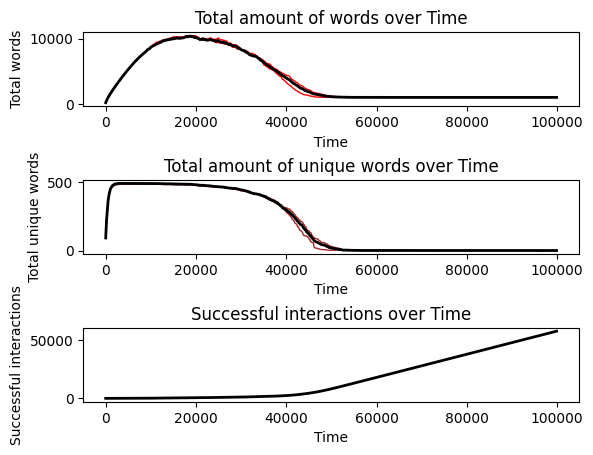

In [69]:
model_df["scaled_index"] = model_df.index * 100
single_run1_model_data["scaled_index"] = single_run1_model_data.index * 100
single_run2_model_data["scaled_index"] = single_run2_model_data.index * 100
fig, axs = plt.subplots(nrows=3)

#figure showing all total words over time
g = sns.lineplot(data=single_run1_model_data[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="red", linewidth=1)
g = sns.lineplot(data=single_run2_model_data[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="red", linewidth=1)
g = sns.lineplot(data=model_df[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="black", linewidth=2)
g.set(title="Total amount of words over Time", ylabel="Total words", xlabel="Time")

#figure showing all unique words over time
g = sns.lineplot(data=single_run1_model_data[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="brown", linewidth=1)
g = sns.lineplot(data=single_run2_model_data[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="brown", linewidth=1)
g = sns.lineplot(data=model_df[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="black", linewidth=2)
g.set(title="Total amount of unique words over Time", ylabel="Total unique words", xlabel="Time")

#figure showing all successful interactions over time
g = sns.lineplot(data=model_df[["Successful_interactions", "scaled_index"]], x="scaled_index", y="Successful_interactions", 
                 ax=axs[2], color="black", linewidth=2)
g.set(title="Successful interactions over Time", ylabel="Successful interactions", xlabel="Time")

#smaller figure showing succesful interactions over time with overlaid s(t)=3t/N^2

plt.subplots_adjust(hspace=1)